<a href="https://colab.research.google.com/github/lephuocdat2000/Advanced-CV/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tf2_yolov4

     |████████████████████████████████| 686kB 37.1MB/s 


In [3]:
import tensorflow as tf
#from tensorflow.python.keras.engine import training
from tf2_yolov4.anchors import YOLOV4_ANCHORS
from tf2_yolov4.model import YOLOv4
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import cv2
import timeit

WIDTH,HEIGHT=(1024,768)

model = YOLOv4(
        input_shape=(HEIGHT,WIDTH,3),
        anchors= YOLOV4_ANCHORS,
        num_classes= 80,
        training=False,
        yolo_max_boxes=50,
        yolo_iou_threshold=0.5,
        yolo_score_threshold=0.5,    
)
CLASSES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
    'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'dining table', 'toilet', 'tv', 'laptop',  'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
model.load_weights('/content/drive/MyDrive/Pretrained/yolov4.h5')

In [13]:
def images_processing(model,image):
    image=tf.convert_to_tensor(image,dtype=tf.float32)
    #image = tf.io.decode_image(image)   #convert input -> tensor
    #image = tf.image.resize(image,(HEIGHT,WIDTH)) 
    images = tf.expand_dims(image,axis=0) / 255 # shape=(batch,(image.shape)) 
    boxes, scores, classes, detections = model.predict(images)
    human_index = np.where(classes[0]==0)
    boxes = np.array(itemgetter(*human_index)(boxes[0]))* [WIDTH, HEIGHT, WIDTH, HEIGHT]
    scores = np.array(itemgetter(*human_index)(scores[0]))
    classes = np.array(itemgetter(*human_index)(classes[0])).astype(int)       
    return images*255,boxes,detections
def video_processing(model,video_path):
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened()==False): 
        print('Error opening video stream or file')
    else: 
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output.avi',fourcc, 20, (1024,768))
      while (True):
          ret, frame = cap.read()
          if ret==True:
            frame = cv2.resize(frame,(1024,768))
            images,boxes,scores,classes,detections = images_processing(model,frame)  
            frame=np.uint8(images[0])
            if detections > 0:
                    image_rect = frame.copy()
                    for (xmin,ymin,xmax,ymax) in boxes:
                        cv2.rectangle(image_rect,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)      
                    out.write(image_rect) 
            else: out.write(frame)
            if cv2.waitKey(1)==ord('q'): break
          else: break 
    out.release()
    return
def show_webcam(mirror=False):
    vid = cv2.VideoCapture(0)
    while True:
       ret,frame = vid.read()
       plt.imshow('frame',frame)
       if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    vid.release()
    cv2.destroyAllWindows()

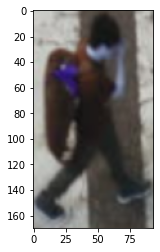

In [40]:
image_path= '/content/istockphoto-1015942804-640x640.jpg'
#image=cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
video_path='/content/drive/MyDrive/Advanced-CV/1064282191-preview.mp4'
img = cv2.imread(image_path)
image = img.copy()
image = cv2.resize(image,(1024,768))
images,boxes,detections=images_processing(model,image)               
(xmin,ymin,xmax,ymax) = boxes[0]
A = [xmin,ymin]
B = [xmin,ymax]
C = [xmax,ymax]
D = [xmax,ymin]
width = int(np.sqrt((A[0]-D[0])**2 + (A[1]-D[1])**2))
height = int(np.sqrt((A[0] - B[0]) ** 2 + (A[1] - B[1]) ** 2))
# # width_AD = np.sqrt((A[0]-D[0])**2 + (A[1]-D[1])**2)
# # width_BC = np.sqrt((B[0]-C[0])**2 + (B[1]-C[1])**2)
# # maxWidth = max(int(width_AD),int(width_BC))
# # height_AB = np.sqrt((A[0] - B[0]) ** 2 + (A[1] - B[1]) ** 2)
# # height_CD = np.sqrt((C[0] - D[0]) ** 2 + (C[1] - D[1]) ** 2)
# # maxHeight = max(int(height_AB), int(height_CD))
inputs = np.float32([A,B,C,D])
outputs = np.float32([[0,0],
                      [0,height-1],
                      [width-1,height-1],
                      [width-1,0]])
M = cv2.getPerspectiveTransform(inputs,outputs)
out =  cv2.warpPerspective(image,M,(width,height),flags=cv2.INTER_LINEAR)
plt.imshow(out)
    #cv2.rectangle(image_rect,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2) 
#video_processing(model,video_path)
#show_webcam()

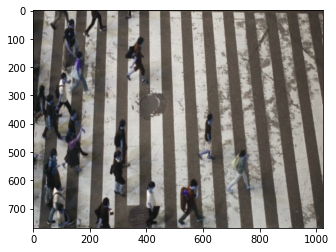

In [41]:
plt.imshow(image)